<a href="https://colab.research.google.com/github/arashash/Deep-Learning-Course-Tutorials/blob/main/W3_MLPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Multi-layer Perceptrons (MLPs)

**By Arash Ash, adapted from Neuromatch Academy [contents](https://github.com/NeuromatchAcademy/course-content-dl)**

---
# Tutorial objectives

In this tutorial, we will explore the Multi-layer Perceptrons (MLPs). MLPs are arguably one of the most tractable models (due to their flexibility) that we can use to study deep learning fundamentals. Here we will learn why they are: 

* similar to biological networks
* good at function approximation
* implemented the way they are in PyTorch

---
# Setup

This is a GPU free notebook!

In [1]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W1D3_T1','https://portal.neuromatchacademy.org/api/redirect/to/9c55f6cb-cdf9-4429-ac1c-ec44fe64c303')

In [2]:
# Imports
import random

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from IPython.display import display
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [4]:
# @title Plotting functions

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def plot_function_approximation(x, relu_acts, y_hat):
  fig, axes = plt.subplots(2, 1)

  # Plot ReLU Activations
  axes[0].plot(x, relu_acts.T);
  axes[0].set(xlabel='x',
              ylabel='Activation',
              title='ReLU Activations - Basis Functions')
  labels = [f"ReLU {i + 1}" for i in range(relu_acts.shape[0])]
  axes[0].legend(labels, ncol = 2)

  # Plot function approximation
  axes[1].plot(x, torch.sin(x), label='truth')
  axes[1].plot(x, y_hat, label='estimated')
  axes[1].legend()
  axes[1].set(xlabel='x',
              ylabel='y(x)',
              title='Function Approximation')

  plt.tight_layout()
  plt.show()

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


---
# Section 1: MLPs and Function Approximation Theorem

In [8]:
# @title Video 0: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1E3411r7TL", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Gh0KYl7ViAc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

#add event to airtable
atform.add_event('Video : Introduction')

# display(out)

## Coding Exercise 1: Function approximation with ReLU
We learned that one hidden layer MLPs are enough to approximate any smooth function! Now let's manually fit a sine function using ReLU activation. 

We will approximate the sine function using a linear combination (a weighted sum) of ReLUs with slope 1. We need to determine the bias terms (which determines where the ReLU inflection point from 0 to linear occurs) and how to weight each ReLU. The idea is to set the weights iteratively so that the slope changes in the new sample's direction.

First, we generate our "training data" from a sine function using `torch.sine` function.

```python
>>> import torch
>>> torch.manual_seed(2021)
<torch._C.Generator object at 0x7f8734c83830>
>>> a = torch.randn(5)
>>> print(a)
tensor([ 2.2871,  0.6413, -0.8615, -0.3649, -0.6931])
>>> torch.sin(a)
tensor([ 0.7542,  0.5983, -0.7588, -0.3569, -0.6389])
```

These are the points we will use to learn how to approximate the function. We have 10 training data points so we will have 9 ReLUs (we don't need a ReLU for the last data point as we don't have anything to the right of it to model). 

We first need to figure out the bias term for each ReLU and compute the activation of each ReLU where:

\begin{equation}
y(x) = \text{max}(0,x+b)
\end{equation}

We then need to figure out the correct weights on each ReLU so the linear combination approximates the desired function.

In [9]:
def approximate_function(x_train, y_train):
  # Number of relus
  n_relus = x_train.shape[0] - 1

  # x axis points (more than x train)
  x = torch.linspace(torch.min(x_train), torch.max(x_train), 1000)

  ## COMPUTE RELU ACTIVATIONS
  # First determine what bias terms should be for each of `n_relus` ReLUs
  b = - x_train[:-1]

  # Compute ReLU activations for each point along the x axis (x)
  relu_acts = torch.zeros((n_relus, x.shape[0]))

  for i_relu in range(n_relus):
    relu_acts[i_relu, :] = torch.relu(x + b[i_relu])

  ## COMBINE RELU ACTIVATIONS
  # Set up weights for weighted sum of ReLUs
  combination_weights = torch.zeros((n_relus, ))

  ####################################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Complete approximate_function!")
  ####################################################################
  prev_slope = 0
  for i in range(n_relus):
    # Figure out weights on each ReLU
    delta_x = x_train[i+1] - x_train[i]
    slope = ...
    combination_weights[i] = slope - prev_slope
    prev_slope = slope

  # Get output of weighted sum of ReLU activations for every point along x axis
  y_hat = ...

  return y_hat, relu_acts, x

# add event to airtable
atform.add_event('Coding Exercise 1: Function approximation with ReLU')


# Make training data from sine function
N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)

## Uncomment the lines below to test your function approximation
# y_hat, relu_acts, x = approximate_function(x_train, y_train)
# plot_function_approximation(x, relu_acts, y_hat)

As you see in the top panel, we obtain 9 shifted ReLUs with the same slope. These are the basis functions that MLP uses to span the functional space, i.e., MLP finds a linear combination of these ReLUs.

---
# Section 2: MLPs in Pytorch

In [17]:
# @title Video 2: Building MLPs in PyTorch
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1zh411z7LY", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"XtwLnaYJ7uc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Building MLPs in PyTorch')

# display(out)

In the previous segment, we implemented a function to approximate any smooth function using MLPs. We saw that using Lipschitz continuity; we can prove that our approximation is mathematically correct. MLPs are fascinating, but before we get into the details on designing them, let's familiarize ourselves with some basic terminology of MLPs- layer, neuron, depth, width, weight, bias, and activation function. Armed with these ideas, we can now design an MLP given its input, hidden layers, and output size.

## Coding Exercise 2: Implement a general-purpose MLP in Pytorch
The objective is to design an MLP with these properties:
* works with any input (1D, 2D, etc.)
* construct any number of given hidden layers using `nn.Sequential()` and `add_module()` function
* use the same given activation function (i.e., [Leaky ReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html)) in all hidden layers.

**Leaky ReLU** is described by the following mathematical formula:

\begin{equation}
\text{LeakyReLU}(x) = \text{max}(0,x) + \text{negative_slope} \cdot \text{min}(0, x) =
\left\{
  \begin{array}{ll}
  x & ,\; \text{if} \; x \ge 0 \\
  \text{negative_slope} \cdot x & ,\;  \text{otherwise}
  \end{array}
\right.
\end{equation}

In [11]:
class Net(nn.Module):
  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      ####################################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your function
      raise NotImplementedError("Create MLP Layer")
      ####################################################################

      out_num = hidden_unit_nums[i] # assign the current layer hidden unit from list
      layer = ... # use nn.Linear to define the layer
      in_num = out_num # assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # append the final layer

  def forward(self, x):
    # reshape inputs to (batch_size, input_feature_num)
    # just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Run MLP model")
    ####################################################################

    logits = ... # forward pass of MLP
    return logits

# add event to airtable
atform.add_event('Coding Exercise 2: Implement a general-purpose MLP in Pytorch')


input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
# net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
# y = net(input.to(DEVICE))
# print(f'The output shape is {y.shape} for an input of shape {input.shape}')

In [12]:
# to_remove solution
class Net(nn.Module):
  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one

      out_num = hidden_unit_nums[i] # assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # use nn.Linear to define the layer
      in_num = out_num # assign next layer input using current layer output
      self.mlp.add_module('Linear_%d'%i, layer) # append layer to the model with a name

      actv_layer = eval('nn.%s'%actv) # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module('Activation_%d'%i, actv_layer) # append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # append the final layer

  def forward(self, x):
    # reshape inputs to (batch_size, input_feature_num)
    # just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits

# add event to airtable
atform.add_event('Coding Exercise 2: Implement a general-purpose MLP in Pytorch')


input = torch.zeros((100, 2))
## Uncomment below to create network and test it on input
net = Net(actv='LeakyReLU(0.1)', input_feature_num=2, hidden_unit_nums=[100, 10, 5], output_feature_num=1).to(DEVICE)
y = net(input.to(DEVICE))
print(f'The output shape is {y.shape} for an input of shape {input.shape}')

The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])


```
The output shape is torch.Size([100, 1]) for an input of shape torch.Size([100, 2])
```

---
# Neuron Physiology and Motivation to Deep Learning

This section will motivate one of the most popular nonlinearities in deep learning, the ReLU nonlinearity, by starting from the biophysics of neurons and obtaining the ReLU nonlinearity through a sequence of approximations. We will also show that neuronal biophysics sets a time scale for signal propagation speed through the brain. This time scale implies that neural circuits underlying fast perceptual and motor processing in the brain may not be excessively deep. 

This biological motivation for deep learning is not strictly necessary to follow the rest of this course, so this section can be safely skipped and **is a bonus section**.

In [13]:
# @title Video 5: Biological to Artificial Neurons
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1mf4y157vf", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ELAbflymSLo", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Biological to Artificial Neurons')

# display(out)

## Leaky Integrate-and-fire (LIF)
The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The model dynamics is defined with the following formula,


\begin{equation}
\frac{d V}{d t}=\left\{\begin{array}{cc}
\frac{1}{C}\left(-\frac{V}{R}+I \right) & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
\end{equation}


Note that $V$, $C$, and $R$ are the membrane voltage, capacitance, and resitance of the neuron respectively and $-\frac{V}{R}$ is the leakage current. When $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, it momentarily spikes and then $V$ is reset to $V_{\rm reset}< V_{\rm th}$, and voltage stays at $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential (note that $V_{\rm reset}$ and $\tau_{\rm ref}$ is assumed to be zero in the lecture):


\begin{eqnarray}
V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}


where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

Thus, the LIF model captures the facts that a neuron:
- performs spatial and temporal integration of synaptic inputs 
- generates a spike when the voltage reaches a certain threshold
- goes refractory during the action potential
- has a leaky membrane 

For in-depth content on computational models of neurons, follow the [NMA](https://www.neuromatchacademy.org/) tutorial 1 of *Biological Neuron Models*. Specifically, for NMA-CN 2021 follow this [Tutorial](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D3_BiologicalNeuronModels/W2D3_Tutorial1.ipynb).


## Simulating an LIF Neuron

In the cell below is given a function for LIF neuron model with it's arguments described.

Note that we will use Euler's method to make a numerical approximation to a derivative. Hence we will use the following implementation of the model dynamics,

\begin{equation}
V_n=\left\{\begin{array}{cc}
V_{n-1} + \frac{1}{C}\left(-\frac{V}{R}+I \right) \Delta t & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
\end{equation}

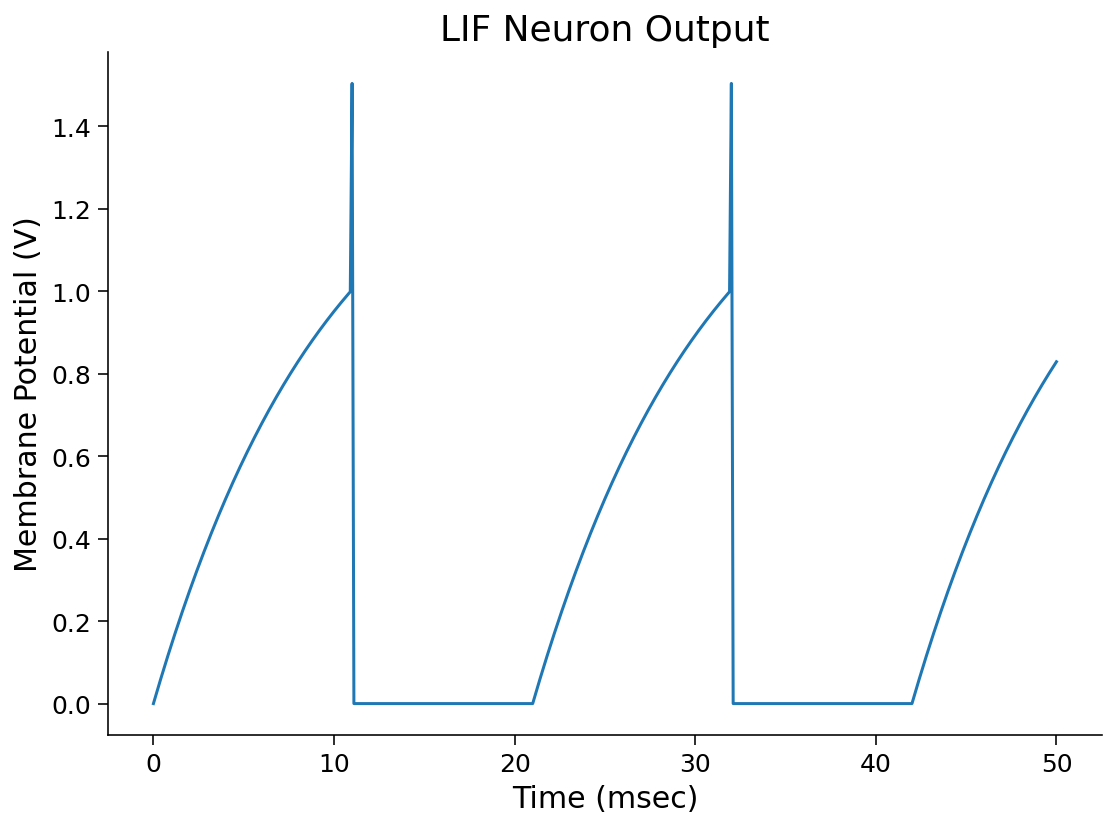

In [14]:
def run_LIF(I, T=50, dt=0.1, t_ref=10,
            Rm=1, Cm=10, Vth=1, V_spike=0.5):
  """
  Simulate the LIF dynamics with external input current

  Args:
    I          : input current (mA)
    T          : total time to simulate (msec)
    dt         : simulation time step (msec)
    t_ref      : refractory period (msec)
    Rm         : resistance (kOhm)
    Cm         : capacitance (uF)
    Vth        : spike threshold (V)
    V_spike    : spike delta (V)

  Returns:
    time       : time points
    Vm         : membrane potentials
  """

  # Set up array of time steps
  time = torch.arange(0, T+dt, dt)

  # Set up array for tracking Vm
  Vm = torch.zeros(len(time))

  # Iterate over each time step
  t_rest = 0
  for i, t in enumerate(time):

    # If t is after refractory period
    if t > t_rest:
      Vm[i] = Vm[i-1] + 1/Cm*(-Vm[i-1]/Rm + I)  * dt

    # If Vm is over the threshold
    if Vm[i] >= Vth:

      # Increase volatage by change due to spike
      Vm[i] += V_spike

      # Set up new refactory period
      t_rest = t + t_ref

  return time, Vm


sim_time, Vm = run_LIF(1.5)
# Plot the membrane voltage across time
plt.plot(sim_time, Vm)
plt.title('LIF Neuron Output')
plt.ylabel('Membrane Potential (V)')
plt.xlabel('Time (msec)')
plt.show()

### Interactive Demo: Neuron's transfer function explorer for different $R_m$ and $t_{ref}$
We know that real neurons communicate by modulating the spike count meaning that more input current causes a neuron to spike more often. Therefore, to find an input-output relationship, it makes sense to characterize their spike count as a function of input current. This is called the neuron's input-output transfer function. Let's plot the neuron's transfer function and see how it changes with respect to the **membrane resistance** and **refractory time**? 

In [15]:
# @title

# @markdown Make sure you execute this cell to enable the widget!
my_layout = widgets.Layout()

@widgets.interact(Rm=widgets.FloatSlider(1., min=1, max=100.,
                                         step=0.1, layout=my_layout),
                  t_ref=widgets.FloatSlider(1., min=1, max=100.,
                                            step=0.1, layout=my_layout)
                  )


def plot_IF_curve(Rm, t_ref):
  T = 1000 # total time to simulate (msec)
  dt = 1 # simulation time step (msec)
  Vth = 1 # spike threshold (V)
  Is_max = 2
  Is = torch.linspace(0, Is_max, 10)
  spike_counts = []
  for I in Is:
    _, Vm = run_LIF(I, T=T, dt=dt, Vth=Vth, Rm=Rm, t_ref=t_ref)
    spike_counts += [torch.sum(Vm > Vth)]

  plt.plot(Is, spike_counts)
  plt.title('LIF Neuron: Transfer Function')
  plt.ylabel('Spike count')
  plt.xlabel('I (mA)')
  plt.xlim(0, Is_max)
  plt.ylim(0, 80)
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='Rm', min=1.0), FloatSlider(value=1.0, description='t…

### Think!: Real and Artificial neuron similarities

What happens at infinite membrane resistance ($R_m$) and small refactory time ($t_{ref}$)? Why?

Take 10 mins to discuss the similarity between a real neuron and an artificial one with your pod.

In [16]:
# to_remove explanation

"""
At infinite membrane resistance, the Neuron does not leak any current out,
and hence it starts firing with the slightest input current,
This shifts the transfer function towards 0, similar to ReLU activation (centered at 0).
Also, when there is minimal refractory time, the neuron can keep firing
at a high input current which avoids the saturation.
""";

---
# Summary

In this tutorial we have explored the Multi-leayer Perceptrons (MLPs). More specifically, we have discuss the similarities of artificial and biological neural networks (for more information see the Bonus section), we have learned the Universal Approximation Theorem, and we have implemented MLPs in PyTorch.